In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import re

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/amazon-merged-dataset/mergeddata (1).csv


## Generating a one-hot encoded matrix for all the tags

In [2]:
%%time
merged = pd.read_csv(r'../input/amazon-merged-dataset/mergeddata (1).csv')
def my_tokenizer(s):
    #s = s.replace(', ',',') # So that blank does NOT become an encoding
    s = re.split(', ',s) #Seperate tags after each comma
    #s = s.split('/&') #Seperate tags after each &
    return s
merged['category'] = merged['category'].apply(lambda x: x.replace('[','').replace(']','').replace('\'',''))
#merged = merged.drop_duplicates(subset='asin',keep='first')
from sklearn.feature_extraction.text import CountVectorizer
vec = CountVectorizer(tokenizer = my_tokenizer, 
                      lowercase = True,
                      min_df = 0.005, # Should appear as a tag in atleast 0.5% of all products
                      #max_features = 100,  # a maximum of top 250 tags after the above exclusion will be considered,
                      stop_words = ['electronics'] #THIS STOP-WORD WOULD NOT BE USED ONCE EXPANDING ONTO OTHER CATEGORIES
                     )
X = vec.fit_transform(merged['category'])
tags = pd.DataFrame(X.toarray(), columns=vec.get_feature_names())

CPU times: user 2.67 s, sys: 403 ms, total: 3.08 s
Wall time: 3.62 s


## Checking the top 10 tags in terms of occurrence

In [3]:
sum_words = X.sum(axis=0)

In [4]:
words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)

In [5]:
words_freq[:10]

[('computers & accessories', 44377),
 ('camera & photo', 29599),
 ('accessories & supplies', 14063),
 ('computer accessories & peripherals', 12574),
 ('audio & video accessories', 10539),
 ('computer components', 8256),
 ('bags', 7547),
 ('cases & sleeves', 7536),
 ('accessories', 7200),
 ('tablet accessories', 6942)]

## Generating the cosine similarity matrix for a very simple recommendation system

In [6]:
from sklearn.metrics.pairwise import cosine_similarity
similarities = cosine_similarity(X.transpose())

In [7]:
sim = pd.DataFrame(similarities, columns=list(vec.vocabulary_.keys()), index=list(vec.vocabulary_.keys()))

In [8]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components = 2, init = 'random', random_state = 10, perplexity = 100)

tsne_df = tsne.fit_transform(X.transpose())

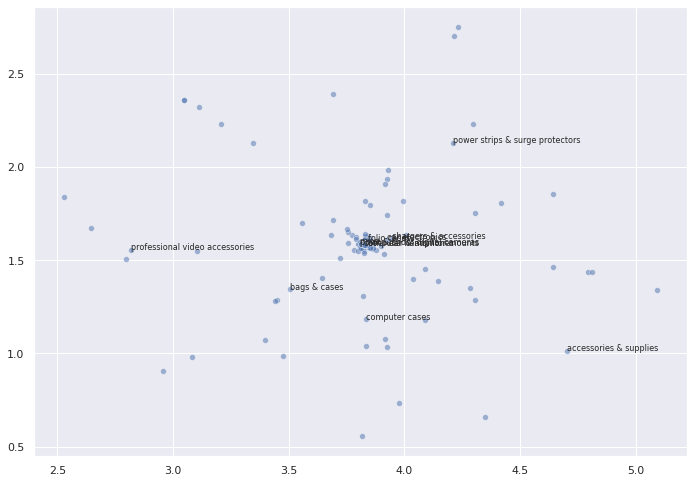

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()
# Initialize figure
fig, ax = plt.subplots(figsize = (11.7, 8.27))
sns.scatterplot(tsne_df[:, 0], tsne_df[:, 1], alpha = 0.5)

# Import adjustText, initialize list of texts
texts = []
words_to_plot = list(np.arange(0, len(sim), 10))

# Append words to list
for word in words_to_plot:
    texts.append(plt.text(tsne_df[word, 0], tsne_df[word, 1], sim.index[word], fontsize = 8))
    
plt.show()

## Let us check similar tags for a random product

From the below list of categories the office supplies

In [10]:
random_product = merged[42:43]
tags = merged['category'][42:43].str.lower().str.split(', ').values[0][1:]
tags

['accessories & supplies', 'office electronics accessories', 'labeling tapes']

In [11]:
#Getting tags with similarity greater than 0 and less than 1 (as they occur with the tags always)
cleaned_tags = []
for tag in tags:
    if tag in sim.columns:
        cleaned_tags.append(tag)
subset = sim[cleaned_tags]
similar_tags = subset[subset > 0][subset <=0.999].dropna(how='all',axis=0).fillna(0).sum(axis=1) #stores the sums of cosine similarity for each tag

In [12]:
similar_categories = similar_tags[similar_tags.gt(0.2)].sort_values(ascending = False) #we want to see a min cumulative cosine similarity of 0.2 between the tags
similar_categories

cases                              0.458338
hubs                               0.395285
vehicle electronics accessories    0.373609
filters & accessories              0.355707
on-dash cameras                    0.330404
hdmi cables                        0.312916
memory card accessories            0.295804
over-ear headphones                0.283088
dtype: float64

## From the above list of tags, we see other office supplies are listed

These can be used for recommendation and search optimization for different cut-off points